# How to use Google calendar API?

How to authorize Google calendar?



In [ ]:
var {google} = require('googleapis');
var importer = require('../Core');
var authorize = importer.import('google oauth token client');

// Authorize a client with the loaded credentials, then call the
// Google Calendar API.
var oauth2Client;
function authorizeCalendar(options = {}) {
    var calendar;
    if(options.auth) {
        return Promise.resolve(google.calendar({version: 'v3', auth: options.auth}))
    }
    return authorize(options.scopes || [
            'https://www.googleapis.com/auth/calendar'])
        .then(c => {
            options.auth = c;
            calendar = google.calendar({version: 'v3', auth: c});
            return calendar;
        })
        .then(() => calendar);
}

module.exports = authorizeCalendar;



How to list events?

In [ ]:
var importer = require('../Core');
var {
    authorizeCalendar,
    correctTimeLimits,
    correctCalendarId
} = importer.import([
    'authorize google calendar',
    'correct dates time',
    'lookup calendar name'
]);

function processResult(response, options) {
    var resultEvents = []; // reset the array
    var events = response.data.items;
    if (events.length === 0) {
        const q = Object.assign({}, options);
        q.auth = null;
        console.log('No events found for ' + JSON.stringify(q));
    } else {
        for (var i = 0; i < events.length; i++) {
            var event = events[i];
            var start = event.start.dateTime || event.start.date;
            resultEvents[resultEvents.length] = {
                start: new Date(start), event: event
            };
        }
    }
    return resultEvents;
};


/**
 * Lists the next 10 events on the user's primary calendar.
 *
 * @param {google.auth.OAuth2} auth An authorized OAuth2 client.
 */
function listEvents(options = {calendarId: 'primary'}) {
    let calendar, events = [];
    return authorizeCalendar(options)
        .then(c => calendar = c)
        .then(() => correctTimeLimits(options))
        .then(() => correctCalendarId(options))
        .then(() => {
            var data = Object.assign({}, options, {
                maxResults: 1000,
                singleEvents: true,
                orderBy: 'startTime'
            });
            return new Promise((resolve, reject) => {
                calendar.events.list(data, (err, response) => {
                    if (err) reject(err);
                    try {
                        return resolve(response);
                    } catch (e) {
                        return reject(e);
                    }
                });
            })
        })
        .then(response => {
            events = events.concat(processResult(response, options));
            if(response.nextPageToken) {
                console.log('paging ' + response.nextPageToken)
                return listEvents(Object.assign({pageToken: response.nextPageToken}, options))
                    .then(e => events.concat(e));
            }
            return events;
        })
};
module.exports = listEvents;



Run todays calendar events?



In [ ]:
var importer = require('../Core');
var {JSDOM} = require('jsdom');
var {
    listEvents,
    storeResult
} = importer.import([
    'list events',
    'import google calendar api',
    'store rpc result'
]);

var options = {
    calendarId: 'commands'
};

// test Google calendar API?
function runTodaysEvents(calendar) {
    if(calendar) {
        options.calendarId = calendar;
    }
    return listEvents({
            auth: options.auth,
            calendarId: options.calendarId,
            timeMin: '12 AM today',
            timeMax: 'next hour today'
        })
        // filter processed
        .then(events => {
            // TODO: create object with property "already" and filter out like other RPC methods?
            // determine if the event has already been run today by matching it with the result
            const commandEvent = events
                .filter(e => {
                    const matches = events
                        .filter(m => 'Result: ' + e.event.summary === m.event.summary
                            && e.event.start.dateTime === m.event.start.dateTime);
                    return e.event.summary.indexOf('Result:') === -1 && matches.length === 0
                })[0]
            if (typeof commandEvent === 'undefined') throw new Error('No events!');
            // parse parameters from event description
            var parameters;
            try {
                var dom = new JSDOM('<body>' + (commandEvent.event.description || '""').replace(/<br\/?>/igm, '\n') + '</body>');
                parameters = JSON.parse(dom.window.document.body.textContent);
            } catch ( e ) {
                parameters = (commandEvent.event.description || '').trim().split(/\n/ig);
            }
            return {
                already: false, // filtered out above
                body: parameters,
                name: 'Today\'s events',
                command: commandEvent.event.summary.trim(),
                date: new Date(commandEvent.event.start.dateTime),
                id: commandEvent.event.summary.trim(),
                circles: ['Function', 'Selenium'],
                result: importer.interpret(commandEvent.event.summary.trim()),
                allowed: true // TODO: use RPC filter because it's safer?
            };
        })
        // use rpc
        .then(f => storeResult(f, options.calendarId))
        .catch(e => console.log(e))
};
module.exports = runTodaysEvents;

// node -e "require('/Users/briancullinan/jupytangular2/Core').import('heartbeat')('run todays calendar events')"

// echo "require('/Users/briancullinan/jupytangular2/Core').import('scrape facebook events').then(runner => runner()).then(e=>{console.log(e); process.exit(e) }).catch(e=>{console.log(e); process.exit(e) });" | node



test calendar events


In [ ]:
var importer = require('../Core');
var {
    listEvents,
    correctCalendarId
} = importer.import([
    'list events',
    'import google calendar api',
    'lookup calendar name'
]);

var options = {};
describe('calendar service', () => {
    beforeEach(() => {
    })
    
    it('should list events from around today', (done) => {
        return correctCalendarId(Object.assign(options, {
            calendarId: 'commands'
        }))
        .then(() => listEvents({
            auth: options.auth,
            calendarId: options.calendarId,
            timeMin: '12 AM today',
            timeMax: 'next hour today'
        }))
        .then(r => {
            assert(r.length > 0)
            done()
        })
    })
})


test calendar api graph Iga's cycle for as long as there are valid dates



reading notebook /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb
reading notebook /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb
compiling /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb[0]
compiling /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb[1]
reading notebook /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb
reading notebook /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb
compiling /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb[6]
compiling /Users/briancullinan/jupytangular2/Utilities/google calendar.ipynb[7]
Using calendar: Iga - p4685f6at8ccctenocjlqgnqss@group.calendar.google.com
[ 'Thu Apr 04 2013 12:00:00 GMT-0700 (MST) - 27.833333333333332',
  'Sun Apr 28 2013 13:00:00 GMT-0700 (MST) - 24.041666666666668',
  'Thu May 23 2013 13:00:00 GMT-0700 (MST) - 25',
  'Tue Mar 17 2015 13:00:00 GMT-0700 (MST) - 22.770833333333332',
  'Fri May 08 2015 14

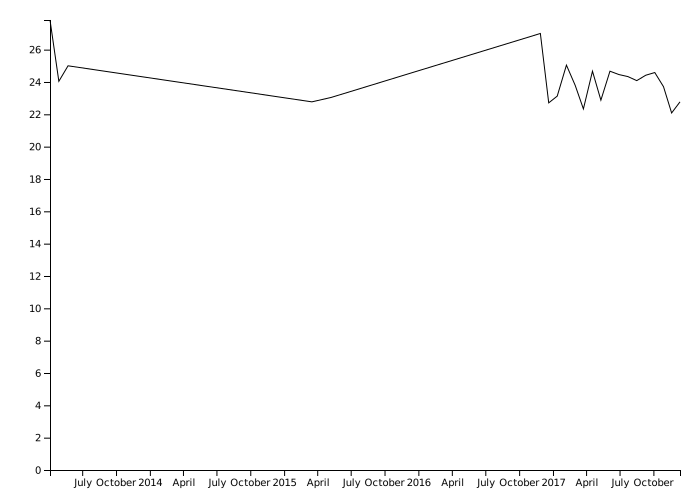

In [4]:
var importer = require('../Core');

var {
    filterDistant,
    listEvents,
    graphDates
} = importer.import([
    'import google calendar api',
    'how to list events',
    'number of days between events',
    'display recurrence line graph'
]);


$$.async();
listEvents({
    q: 'period',
    calendarId: 'p4685f6at8ccctenocjlqgnqss@group.calendar.google.com'
})
    .then(r => {
        var dates = filterDistant(r);
        console.log(dates.map(d => d.start + ' - ' + d.days));
        return $$.svg(graphDates(dates))
    })
    .catch(e => $$.sendError(e));




test calendar sum all hours worked on study sauce since september 2016



In [ ]:
var importer = require('../Core');
var {
    sumEvents, listEvents, ISODateString
} = importer.import([
    'import google calendar api',
    'how to list events',
    'sum a list of events',
    'convert date to ISO'
]);

$$.async();
listEvents({
    timeMin: ISODateString(new Date('2016/09/22')),
    timeMax: ISODateString(new Date('2017/09/22')),
    q: 'study sauce'
})
    .then(r => $$.sendResult(sumEvents(r)))
    .catch(e => $$.sendError(e));



Correct calendar dates for timeMax and timeMin?


In [ ]:
var importer = require('../Core');
var chrono = require('chrono-node');
var ISODateString = importer.import('convert date to ISO');

function correctTimeLimits(options) {
    if (typeof options.timeMin !== 'undefined') {
        options.timeMin = ISODateString(
            chrono.parseDate(options.timeMin));
    }
    if (typeof options.timeMax !== 'undefined') {
        options.timeMax = ISODateString(
            chrono.parseDate(options.timeMax));
    }
    return options;
};
module.exports = correctTimeLimits;



Lookup calendar id by name or id?



In [ ]:
var importer = require('../Core');
var authorizeCalendar = importer.import('authorize google calendar');
var assert = require('assert');
var util = require('util');

var calendarList = [], lastCalendar;

function filterCalendar(options) {
    var rexexp = new RegExp(options.calendarId, 'ig');
    var matches = calendarList
        .filter(c => c.id == options.calendarId);
    if (matches.length == 0) {
        matches = calendarList
            .filter(c => c.summary.match(rexexp));
    }
    assert(matches.length > 0, 'something is seriously wrong with the calendarId ' + JSON.stringify(options, null, 4) + JSON.stringify(calendarList, null, 4));
    if (lastCalendar !== matches[0].summary) {
        lastCalendar = matches[0].summary;
        console.log('Using calendar: ' + matches[0].summary
            + ' - ' + matches[0].id);
    }
    options.calendarId = matches[0].id;
    return options;
}

function correctCalendarId(options) {
    if (typeof options.calendarId === 'undefined' || options.calendarId === 'primary') {
        return Promise.resolve(Object.assign(options, {
            calendarId: 'primary'
        }))
    }
    if (calendarList.length > 0) {
        return filterCalendar(options);
    }
    return (calendarList.length == 0
        ? authorizeCalendar()
            .then(calendar => util.promisify(calendar.calendarList.list.bind(calendar))())
        : Promise.resolve(calendarList))
        .then(r => {
            calendarList = (r.data || {}).items || [];
            return filterCalendar(options);
        })
        .catch(e => console.log(e))
};

module.exports = correctCalendarId;



In [ ]:
var importer = require('../Core');
var {
    fuseSearch, interpretObject
} = importer.import('interpret all notebooks.ipynb');

var queries = 'scrape facebook events';

$$.async();
(r => typeof queries === 'string'
        ? fuseSearch(queries)
        : Promise.all(queries.map(fuseSearch)))
    //.then(r => typeof queries == 'string'
    //      ? interpretObject([r[0]])
    //      : interpretObject(r.map(r => r[0])))
    .then(r => $$.sendResult(r))
    .catch(e => $$.sendError(e));


Show a d3 pie chart of time spent on projects?



In [ ]:
var importer = require('../Core');

var options = {};
var {
    listEvents, sumEvents, d3PieChart
} = importer.import([
    'list events',
    'import google calendar api',
    'sum a list of events',
    'd3 pie chart'
]);

function calendarSearchToPieChart(searches) {
    return importer.runAllPromises(searches
        .map(s => (resolve) => listEvents({
            auth: options.auth,
            q: s
        })
            .then(r => {
                //console.log(s);
                //console.log(r.map(e => e.event.summary));
                resolve({label: s, value: sumEvents(r)})
            })
            .catch(e => console.log(e))))
        .then(r => d3PieChart(r))
        .catch(e => console.log(e))
}

$$.async();
calendarSearchToPieChart([
    'study sauce',
    'portal',
    'renewal',
    'work on sos',
    'jupyter',
    'jupytangular',
    'unit tests',
    'selenium',
    'angular',
    'mind spree',
    '"c#"',
    'docker'
])
    .then(r => $$.svg(r))
    .catch(e => $$.sendError(e))



In [ ]:
var importer = require('../Core');

var options = {};
var {
    listEvents, sumEvents, d3Swimlane
} = importer.import([
    'list events',
    'import google calendar api',
    'sum a list of events',
    'd3 swimlane'
]);

var now = new Date();
function calendarSearchToSwimlane(searches) {
    return importer.runAllPromises(searches
        .map((s, i) => (resolve) => listEvents({
            auth: options.auth,
            q: s
        })
            .then(r => {
                //console.log(s);
                //console.log(r.map(e => e.event.summary));
                resolve(r.map(e => ({
                    id: e.event.id,
                    lane: i,
                    start: new Date(e.event.start.dateTime),
                    end: new Date(e.event.end.dateTime),
                    class: e.event.end.dateTime > now ? 'future' : 'past',
                    desc: e.event.summary
                })));
            })
            .catch(e => console.log(e))))
        .then(r => d3Swimlane({
            lanes: searches.map((s, i) => ({
                id: i,
                label: s
            })),
            items: [].concat(...r)
        }))
        .catch(e => console.log(e))
}

$$.async();
calendarSearchToSwimlane([
    'study sauce',
    'portal',
    'renewal',
    'work on sos',
    'jupyter',
    'jupytangular',
    'unit tests',
    'selenium',
    'angular',
    'mind spree',
    '"c#"',
    'docker'
])
    .then(r => $$.html(r))
    .catch(e => $$.sendError(e))


In [ ]:
var importer = require('../Core');

var options = {};
var {
    listEvents, d3Heatmap
} = importer.import([
    'list events',
    'import google calendar api',
    'd3 calendar'
]);

var now = new Date();
function calendarSearchToHeatmap(searches) {
    return importer.runAllPromises(searches
        .map((s, i) => (resolve) => listEvents({
            auth: options.auth,
            q: s
        })
            .then(r => {
                //console.log(s);
                //console.log(r.map(e => e.event.summary));
                resolve(r.map(e => ({
                    id: e.event.id,
                    start: new Date(e.event.start.dateTime),
                    end: new Date(e.event.end.dateTime),
                })));
            })
            .catch(e => console.log(e))))
        .then(r => d3Heatmap(r))
}

$$.async();
calendarSearchToHeatmap([
    'study sauce',
    /*
    'portal',
    'renewal',
    'work on sos',
    'jupyter',
    'jupytangular',
    'unit tests',
    'selenium',
    'angular',
    'mind spree',
    '"c#"',
    'docker'
    */
])
    .then(r => $$.html(r))
    .catch(e => $$.sendError(e))


days events?


In [ ]:
var chrono = require('chrono-node');
var assert = require('assert');
var importer = require('../Core');
var {
    ISODateString,
    listEvents 
} = importer.import([
    'convert date iso',
    'list events'
]);

function getDaysEvents(startDate, options) {
    var eventCache = {}; // TODO: fix this, move it outside, only update if calendar is modified?
    startDate = chrono.parseDate(startDate + '');
    var day = new Date(startDate);
    day.setHours(0, 0, 0);
    var dayEnd = new Date(day);
    dayEnd.setDate(dayEnd.getDate() + 1);
    var todaysEvents;
    assert(options.calendarId, 'calendarId must be set by now! ' + JSON.stringify(options, null, 4));
    if(typeof eventCache[options.calendarId] === 'undefined') {
        eventCache[options.calendarId] = {};
    }
    if(typeof eventCache[options.calendarId][day.getTime()] !== 'undefined') {
        todaysEvents = Promise.resolve(eventCache[options.calendarId][day.getTime()])
    } else {
        console.log({
            timeMin: ISODateString(new Date(day.getTime())),
            timeMax: ISODateString(new Date(dayEnd.getTime()))
        });
        todaysEvents = listEvents({
            auth: options.auth,
            calendarId: options.calendarId,
            timeMin: ISODateString(new Date(day.getTime())),
            timeMax: ISODateString(new Date(dayEnd.getTime()))
        })
    }
    return todaysEvents
        .then(m => {
            assert(eventCache[options.calendarId], 'something is seriously wrong with the calendar service "' + options.calendarId + '" ' + JSON.stringify(eventCache, null, 4));
            eventCache[options.calendarId][day.getTime()] = m;
            return m.filter(e => e.event.deleted !== true)
        })
}
module.exports = getDaysEvents;


Update create merge delete event?



In [ ]:
var {google} = require('googleapis');
var util = require('util');
var importer = require('../Core');
var chrono = require('chrono-node');
var {JSDOM} = require('jsdom');
var getDaysEvents = importer.import('days events');

var {
    ISODateString, correctCalendarId
} = importer.import([
    'convert date iso',
    'lookup calendar name',
])

function updateEvent(event, options) {
    return correctCalendarId(options)
        .then(() => getDaysEvents(event.start.dateTime, options))
        .then(m => {
            const actionsArray = [];
            const matches = m.filter(match => !match.event.deleted
                && match.event.summary.toLowerCase().trim() === event.summary.toLowerCase().trim()
                && Math.abs(Math.round(new Date(match.event.start.dateTime).getTime() / 1000 / 60)
                    - Math.round(new Date(event.start.dateTime).getTime() / 1000 / 60)) < 29);
            console.log('Matching ' + matches.length);
        
            // TODO: check for existing event if the ID is already set?
            if (matches.length > 0) {
                var unique = [];
                try {
                    let descriptions = JSON.parse(event.description) || [];
                    descriptions = descriptions.concat(
                        ...matches.map(match => {
                            try {
                                return JSON.parse(match.event.description)
                            } catch (e) {
                                return [];
                            }
                        }));
                    const urls = descriptions.map(d => (d || {}).url);
                    unique = descriptions.filter((d, i) => urls.indexOf((d || {}).url) === i);
                } catch (e) {
                    unique = [event.description];
                }
                // TODO: make sure there are no duplicates
                // TODO: move this in to some parsing utility?
                // TODO: deep compare instead of just comparing "url" property?
                // support for objects if there's only one
                unique = unique.length === 1 ? unique[0] : unique;
                // patch the first match
                var newDescription = typeof unique === 'string' ? unique : JSON.stringify(unique, null, 4);
                
                if(matches[0].event.description !== newDescription) {
                    actionsArray.push(util.promisify(
                        calendar.events.patch.bind(calendar.events, {
                            eventId: matches[0].event.id,
                            calendarId: options.calendarId,
                            auth: options.auth,
                            resource: {
                                description: newDescription,
                                colorId: event.colorId
                            }
                        })));
                }

                // TODO: delete the rest
                for (const match of matches.slice(1)) {
                    match.event.deleted = true;
                    actionsArray.push(util.promisify(
                        calendar.events.delete.bind(calendar.events, {
                            eventId: match.event.id,
                            calendarId: options.calendarId,
                            auth: options.auth
                        })));
                }
            } else {
                console.log('adding event ' + event.summary)
                actionsArray.push(util.promisify(
                    calendar.events.insert.bind(calendar.events, {
                        calendarId: options.calendarId,
                        auth: options.auth,
                        resource: event
                    })));
            }
            return importer.runAllPromises(actionsArray);
        })
        .catch(e => console.log(e))
};
module.exports = updateEvent;


create new calendar event?


In [ ]:
var importer = require('../Core');
var {google} = require('googleapis');
var util = require('util');
var {
    correctCalendarId
} = importer.import([
    'lookup calendar name',
    'import google calendar api'
]);

function createNewEvent(summary, description, options) {
    const now = new Date();
    options = options || {};
    const event = {
        summary: summary,
        description: description,
        start: {dateTime: new Date(now.getTime())},
        end: {dateTime: new Date(now.getTime() + 30 * 60 * 1000)}
    }
    if(typeof summary === 'object') {
        Object.assign(event, summary);
        options = description;
    }
    return correctCalendarId(options)
        .then(() => util.promisify(
            calendar.events.insert.bind(calendar.events, {
                calendarId: options.calendarId,
                auth: options.auth,
                resource: event
            })))
}
module.exports = createNewEvent;



Parse bookmarks file?



In [ ]:
var importer = require('../Core');

function chromeDtToDate(st_dt) {
   var microseconds = parseInt(st_dt, 10);
   var millis = microseconds / 1000;
   var past = new Date(1601, 0, 1).getTime();
   return new Date(past + millis);
}

function parseBookmarks() {
    return getAllXPath([
        '//dt[./h3]',
        {
            title: './h3/text()',
            links: [
                './dl/dt/a',
                {
                    url: './@href',
                    time: './@add_date',
                    title: './@text()'
                }
            ],
            children: ['./dl/dt/h3/text()']
        }
    ])
        .then(events => [].concat(...events.map(e => e.links.map(l => Object.assign(l, {folder: e.title})))))
        .then(events => {
            return events.map(e => Object.assign(e, {
                url: e.url + '',
                title: e.title + '',
                time_usec: parseInt(e.time + '')
            }))
                .reduce((links, event) => {
                    // group by nearest half-hour and max out at 10 links
                    var timeGroup = Math.round(chromeDtToDate(event.time_usec).getTime() / 1000 / 60 / 30) * 1000 * 60 * 30;
                    if (typeof links[timeGroup] == 'undefined') {
                        links[timeGroup] = [];
                    }
                    links[timeGroup].push(event)
                    return links;
                }, {})
        });
};
module.exports = parseBookmarks;
parseBookmarks;



sync chrome bookmarks?



In [ ]:
var {JSDOM} = require('jsdom');
var fs = require('fs');
var importer = require('../Core');
var glob = require('glob');
var path = require('path');
var fs = require('fs');
var _ = require('lodash');

var offset = (new Date()).getTimezoneOffset() * 60 * 1000;
// TODO: search using glob but include same list of excludes, how to abstract?
var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var PROJECT_PATH = PROFILE_PATH + '/Downloads';

var {
    ISODateString, updateEvent, correctCalendarId
} = importer.import([
    'import google calendar api',
    'lookup calendar name',
    'convert date iso',
    'update create merge event'
]);
var options = {
    calendarId: 'Bookmarks'
};

function syncChromeBookmarks() {
    var files = glob.sync('Takeout*/Chrome/Bookmarks.html', {cwd: PROJECT_PATH})
        .map(f => path.join(PROJECT_PATH, f));
    files.sort((a, b) => fs.statSync(a).ctime - fs.statSync(b).ctime);
    // parse bookmark html
    var dom = new JSDOM(fs.readFileSync(files.pop()).toString());
    var r = importer.import(['all elements xpath', 'parse bookmarks file'], {
        client: {
            execute: (func, ...args) => Promise.resolve({
                value: func.apply(dom.window.document, args)
            }),
            addCommand: () => {
            }
        },
        document: dom.window.document,
        XPathResult: {ORDERED_NODE_ITERATOR_TYPE: 5}
    });
    var parseBookmarks = r.parseBookmarks;
    return correctCalendarId(options)
        .then(() => parseBookmarks())
        // TODO: copy to chrome history
        .then(links => {
            const groups = Object.keys(links).sort((a, b) => parseInt(b) - parseInt(a));
            console.log(groups.slice(0, 10));
            console.log(new Date(parseInt(groups[0]) - offset * 1000));
            return groups.reduce((acc, t) => {
                const folders = _.groupBy(links[t], l => l.folder);
                return acc.concat(Object.keys(folders).map(f => ({
                    start: {
                        dateTime: ISODateString(new Date(parseInt(t) - offset))
                    },
                    end: {
                        dateTime: ISODateString(new Date(parseInt(t) + 60 * 30 * 1000 - offset))
                    },
                    summary: f,
                    description: JSON.stringify(folders[f], null, 4)
                })))
            }, [])
        })
        .then(results => {
            return importer.runAllPromises(results
                .map(event => resolve => updateEvent(event, options)
                    .then(r => resolve(r))
                    .catch(e => {
                        console.log(e);
                        resolve()
                    })))
        })
        .catch(e => console.log(e))
}
module.exports = syncChromeBookmarks;



sync chrome history?



In [ ]:
var importer = require('../Core');
var url = require('url');
var glob = require('glob');
var path = require('path');
var fs = require('fs');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var PROJECT_PATH = PROFILE_PATH + '/Downloads';

function loadChromeHistory(file) {
    var chromeHistory = {};
    importer.streamJson(file, [true, {emitPath: true}], (match) => {
        if (match.path[0] === 'Browser History' && match.path.length > 1) {
            var timeGroup = Math.round(match.value.time_usec / 60 / 30 / 1000000) * 60 * 30 * 1000;
            if (typeof chromeHistory[timeGroup] === 'undefined') {
                chromeHistory[timeGroup] = [];
            }
            match.value.host = url.parse(match.value.url).hostname;
            var hostAlreadyListed = chromeHistory[timeGroup]
                .filter(h => h.host === match.value.host)
            if (hostAlreadyListed.length === 0) {
                chromeHistory[timeGroup].push(match.value);
            } else {
                if (typeof hostAlreadyListed[0].urls === 'undefined') {
                    hostAlreadyListed[0].urls = {};
                }
                hostAlreadyListed[0].urls[match.value.time_usec] = match.value.url;
            }
        }
    })
    return Promise.resolve(chromeHistory);
}

var {
    ISODateString, updateEvent, correctCalendarId
} = importer.import([
    'import google calendar api',
    'lookup calendar name',
    'convert date iso',
    'update create merge event'
]);

var options = {
    calendarId: 'Bookmarks'
};

function syncChromeHistory() {
    var files = glob.sync('Takeout*/Chrome/BrowserHistory.json', {cwd: PROJECT_PATH})
        .map(f => path.join(PROJECT_PATH, f));
    files.sort((a, b) => fs.statSync(a).ctime - fs.statSync(b).ctime);
    return correctCalendarId(options)
        .then(() => loadChromeHistory(files.pop()))
        .then(links => {
            const groups = Object.keys(links).sort((a, b) => parseInt(b) - parseInt(a));
            console.log(groups.slice(0, 10));
            console.log(new Date(parseInt(Object.keys(links)[0])));
            return Object.keys(links).map(t => ({
                start: {
                    dateTime: ISODateString(new Date(parseInt(t)))
                },
                end: {
                    dateTime: ISODateString(new Date(parseInt(t) + 60 * 30 * 1000))
                },
                summary: 'Chrome activity',
                description: JSON.stringify(links[t], null, 4)
            }))
        })
        .then(results => {
            return importer.runAllPromises(results
                .map(event => resolve => {
                    return updateEvent(event, options)
                        .then(r => resolve(r))
                        .catch(e => {
                            console.log(e);
                            resolve()
                        })
                }))
        })
        .catch(e => console.log(e))
}
module.exports = syncChromeHistory;


sync chrome data?



In [ ]:
var importer = require('../Core');
var path = require('path');
var glob = require('glob');
var fs = require('fs');
var rimraf = require('rimraf');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var DOWNLOADS_PATH = PROFILE_PATH + '/Downloads';

// TODO: run unzip as a service?
function unzip(file) {
    console.log('unzipping ' + file);
    return execCmd('unzip -o "' + file + '"', {cwd: DOWNLOADS_PATH})
}

var {
    googleTakeout, syncChromeHistory, syncChromeBookmarks, execCmd
} = importer.import([
    'order google takeout',
    'sync chrome history',
    'sync chrome bookmarks',
    'spawn child process'
]);
function syncChrome() {
    if(fs.existsSync(DOWNLOADS_PATH + '/Takeout')) {
        rimraf.sync(DOWNLOADS_PATH + '/Takeout');
    }
    var takeouts = glob.sync('takeout-*.zip', {cwd: DOWNLOADS_PATH}).map(f => path.join(DOWNLOADS_PATH, f));
    var takeout = takeouts.sort((a, b) => fs.statSync(a).mtime.getTime() - fs.statSync(b).mtime.getTime()).pop();
    console.log(takeout);
    var shouldDownload = !fs.existsSync(takeout) || (new Date().getTime()) - fs.statSync(takeout).mtime.getTime() > 24 * 60 * 60 * 1000;
    return (shouldDownload
        ? googleTakeout('chrome')
            .then(() => {
                const takeout = path.join(DOWNLOADS_PATH, glob.sync('takeout-*.zip', {cwd: DOWNLOADS_PATH}).pop());
                return unzip(takeout);
            })
        : unzip(takeout))
        .then(() => syncChromeHistory())
        .then(() => syncChromeBookmarks())
}
module.exports = syncChrome;


In [ ]:
var importer = require('../Core');
var syncChrome = importer.import('sync chrome data');
$$.async();
syncChrome()
    .then(r => $$.sendResult(r))
    .catch(e => $$.sendError(e))
